In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import functools as ft
from sklearn.model_selection import train_test_split
from PIL import Image
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report
from pylab import rcParams
import torch.optim as optim
from google.colab import drive
import torchvision
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import torch

In [ ]:
def plot_confusion(prediction, target):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    list_labels_cat = ['ARTEFACTS',
          'BASOPHILES',
          'BLASTES',
          'EOSINOPHILES',
          'ERYTHROBLASTES',
          'LYMPHOCYTES',
          'METAMYELOCYTES',
          'MONOCYTES',
          'MYELOCYTES',
          'NEUTROPHILES',
          'PROMYELOCYTES']
    targ_valids_cat = [list_labels_cat[i] for i in target]
    preds_valids_cat = [list_labels_cat[i] for i in prediction]
    rcParams['figure.figsize'] = 7, 7
    df = pd.DataFrame(confusion_matrix(targ_valids_cat, preds_valids_cat, labels = list_labels_cat, normalize='true'), index = list_labels_cat, columns= list_labels_cat)
    # df = pd.DataFrame(confusion_matrix(targ_valids_cat, preds_valids_cat, labels = list_labels_cat, normalize = 'true'))

    fig = plt.figure()
    sns.heatmap(df, annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')



# Import features

In [ ]:
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


# Understanding an image with Python

Our images are 250x250x3 numpy matrices.

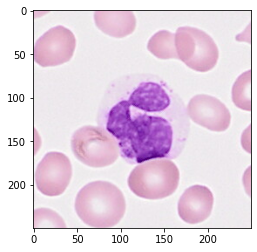

In [ ]:
image = Image.open('/content/drive/MyDrive/TP_ML/allImages_247_282/image1.png').convert('RGB')
image = np.array(image)
plt.imshow(image)

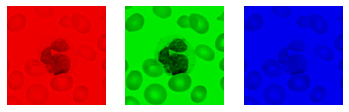

In [ ]:
figure, plots = plt.subplots(ncols=3, nrows=1)
for i, subplot in zip(range(3), plots):
    temp = np.zeros(image.shape, dtype='uint8')
    temp[:,:,i] = image[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

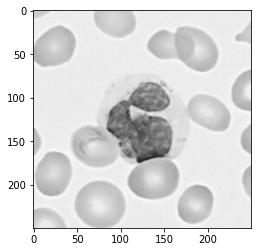

In [ ]:
image_grey = Image.open('/content/drive/MyDrive/TP_ML/allImages_247_282/image1.png').convert('LA')
plt.imshow(image_grey)

# Image transformations

1. Using transforms package, apply the following transformations to *image*:




*   Transform from image to tensor
*   Normalize image so that all pixel values are between 0 and 1, with 0.5 mean and 0.5 standard deviation
*   Crop image
*   Put a random horizontal flip
*   Jitter the colour of the image
*   Add a gaussian blur


Remark: you can use `transforms.Compose` to use several transformations at the same time.


Examples of expected results:

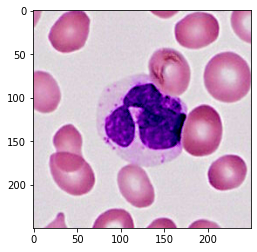


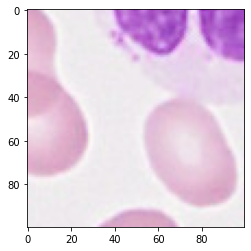

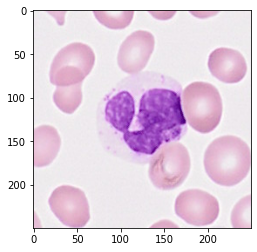

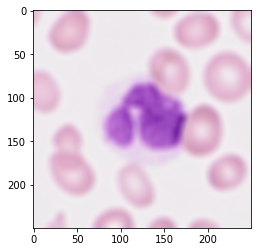



# Add labels

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/TP_ML/labels.csv')

In [ ]:
labels['label'].value_counts()

ERYTHROBLASTES    1324
NEUTROPHILES       760
LYMPHOCYTES        357
ARTEFACTS          237
MONOCYTES          162
BLASTES             93
MYELOCYTES          78
BASOPHILES          69
METAMYELOCYTES      46
EOSINOPHILES         7
PROMYELOCYTES        7
Name: label, dtype: int64

## Labels encoding



2. a. Use the `LabelEncoder() `to convert categorical labels to numbers.

   b. Use `train_test_split` to split the dataset into 2 subdataframes `train` and `test` (test_size = 0.2, random_state = 42)


# Create dataloader

3. Create 2 dataloaders, `dataloader_train` and `dataloader_test` that would form the batches from train and test subdataframes respectively. Use a `batchsize` of 8 and `shuffle=True.`


Help:
You can first create a class `MyDataset` with: 

* 1 attribute: `dataframe`.
* 1 method: `__getitem__ (self, index)` that returns `X,y`, X being the transformed tensor image, and y the associated numerical label.

The tutorial below can provide you some guidance if needed:

https://androidkt.com/load-pandas-dataframe-using-dataset-and-dataloader-in-pytorch/




**Bonus**: Modify `MyDataset` to add the possibility of applying a transform to the image. 


## Visualization of a batch

4. Create one batch by using `next` and `iter` functions on your dataloader, and run the below cell to visualize it.

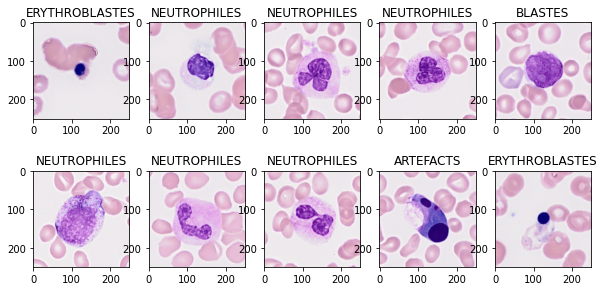

In [ ]:
fig, axes = plt.subplots(2,4, figsize = ((10,5)))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i].permute(2,1,0))
    ax.set_title(classes[batch[1][i].item()])

# Create a model

5. Create a model from scratch, composed of
* and encoder part with convolutional layers with relu activation, and pooling layers. 
* a classifier part with fully connected layers. 

You are free to decide of the architecture of your model.

Warning: the last layer must be composed of as many nodes as there are classes.

## Define loss and optimizer

6. Create `loss` and `optimizer` variables.

`Loss` will be cross entropy loss and `optimizer` will be stochastic gradient descent.

# Training the model

7. Create a function  `train_model(model, epochs, loss, optimizer, dataloader) ` that would train your model on a certain number of epochs `epochs`, using `loss` and `optimizer`.

Warning: you will have to put model and batches from dataloader on the gpu if you want it to run at a decent speed.


8. Use `train_model` to train the model you just created (you can run it for 3 epochs). The training will be done with `dataloader_train`.


# Visualise results

In [ ]:
def find_accuracy(model, dataloader_test):
    correct = 0
    total = 0
    label_test = []
    predicted_test = []

    with torch.no_grad():
        for data in dataloader_test:
            images, labels = data
            label_test+= labels.squeeze().tolist()
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_test += predicted.squeeze().tolist()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return predicted_test, label_test, correct / total

9. a. Find the accuracy of the model on the testing set with the function `find_accuracy`.

  b. Plot the confusion matrix and the classification report of your model on the testing set.

  c. What do you observe ?


Example of expected result:


  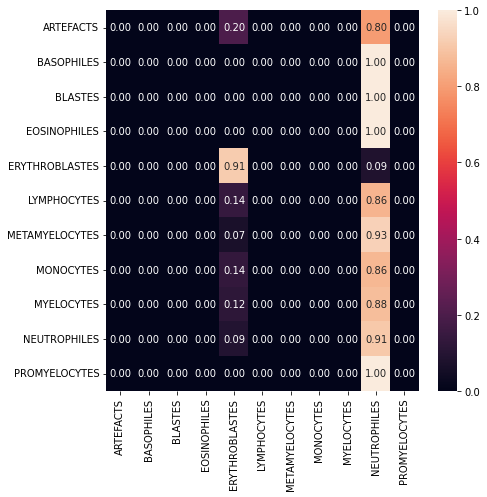

# Using a pretrained model

10. Now we will use a model that has been pretrained on ImageNet dataset. Create a new model by downloading `resnet50` from torch library, with using the option `pretrained = True`.

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

11. Repeat 8 and 9 with your new model. What can you now tell about the pretrained model?





# Dealing with unbalanced classes

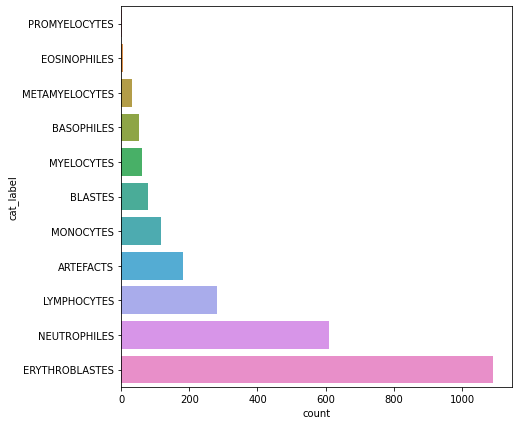

12. Even if results are getting better, underrepresented classes are still hard to classify. Create a new dataloader that would use a `WeightedRandomSampler` to make classes more balanced in every batch, and train again your model. 

Remark: the training will be slower on the overrepresented classes than before, you can use a larger epochs number (such as 10 or more).

What results do you observe?

13. Discuss about the overall results, compared with Machine Learning methods 
used in the first TP.

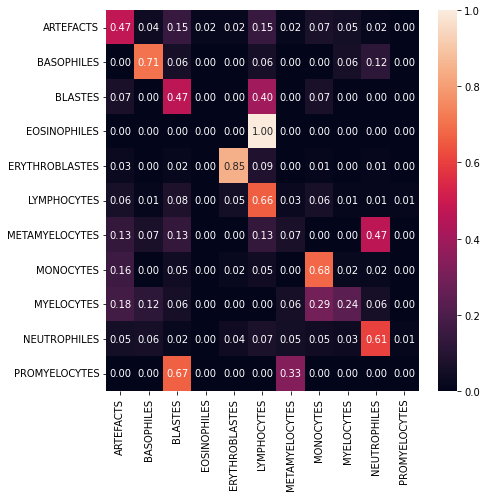

# Go further

If you have made it this far, you can now think about more 'exotic' models that would perform better with few data. 



You can choose between these two options: 

1. Try to create a siamese model. You can think of the best way to later evaluate the performance of your siamese network on this classification task. 

2. Try to integrate features from the TP1 to your neural network, so that you add shape and colour information to the image. The neural network will thus have to handle in parallel table features and images.